# Financial data indices

In [1]:
import json
import math
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={"figure.figsize": (16, 8)})

In [36]:
"""
Some saliencies are virtually 0. 
Here we filter for a given tolerance so that to avoid these values.
"""
def filter_positive(dictionary, key, tol = 0.):
    sal = dictionary[key]
    return { k: v for (k, v) in sal.items() if v > tol }

### Read data generated by .py scripts

In [4]:
with open("data/saliency.json") as file:
    saliency = json.load(file)


summand_dws =  { key: value + saliency["ANNUAL dws b"].get(key, 0.) for key, value in saliency["ANNUAL dws"].items() }    
saliency["ANNUAL dws"] = { **saliency["ANNUAL dws b"], **summand_dws }

saliency.pop("ANNUAL dws b")

# Combine DWS-a and DWS-b

reports = list(saliency)

saliency = {company: filter_positive(saliency, company, tol=0) for company in reports}

In [5]:
types = ["ANNUAL", "RI_REPORT", "STEWARDSHIP_POLICY", "VOTING_POLICY"]
companies = set()

for report in reports:
    name = report
    for t in types:
        name = name.replace(f"{t} ", "")
        
    companies.add(name)
    
companies = list(companies)

In [6]:
companies

['nbim', 'nn', 'blackrock', 'dws', 'apg', 'generali', 'jpmam']

## Distribution of all saliencies

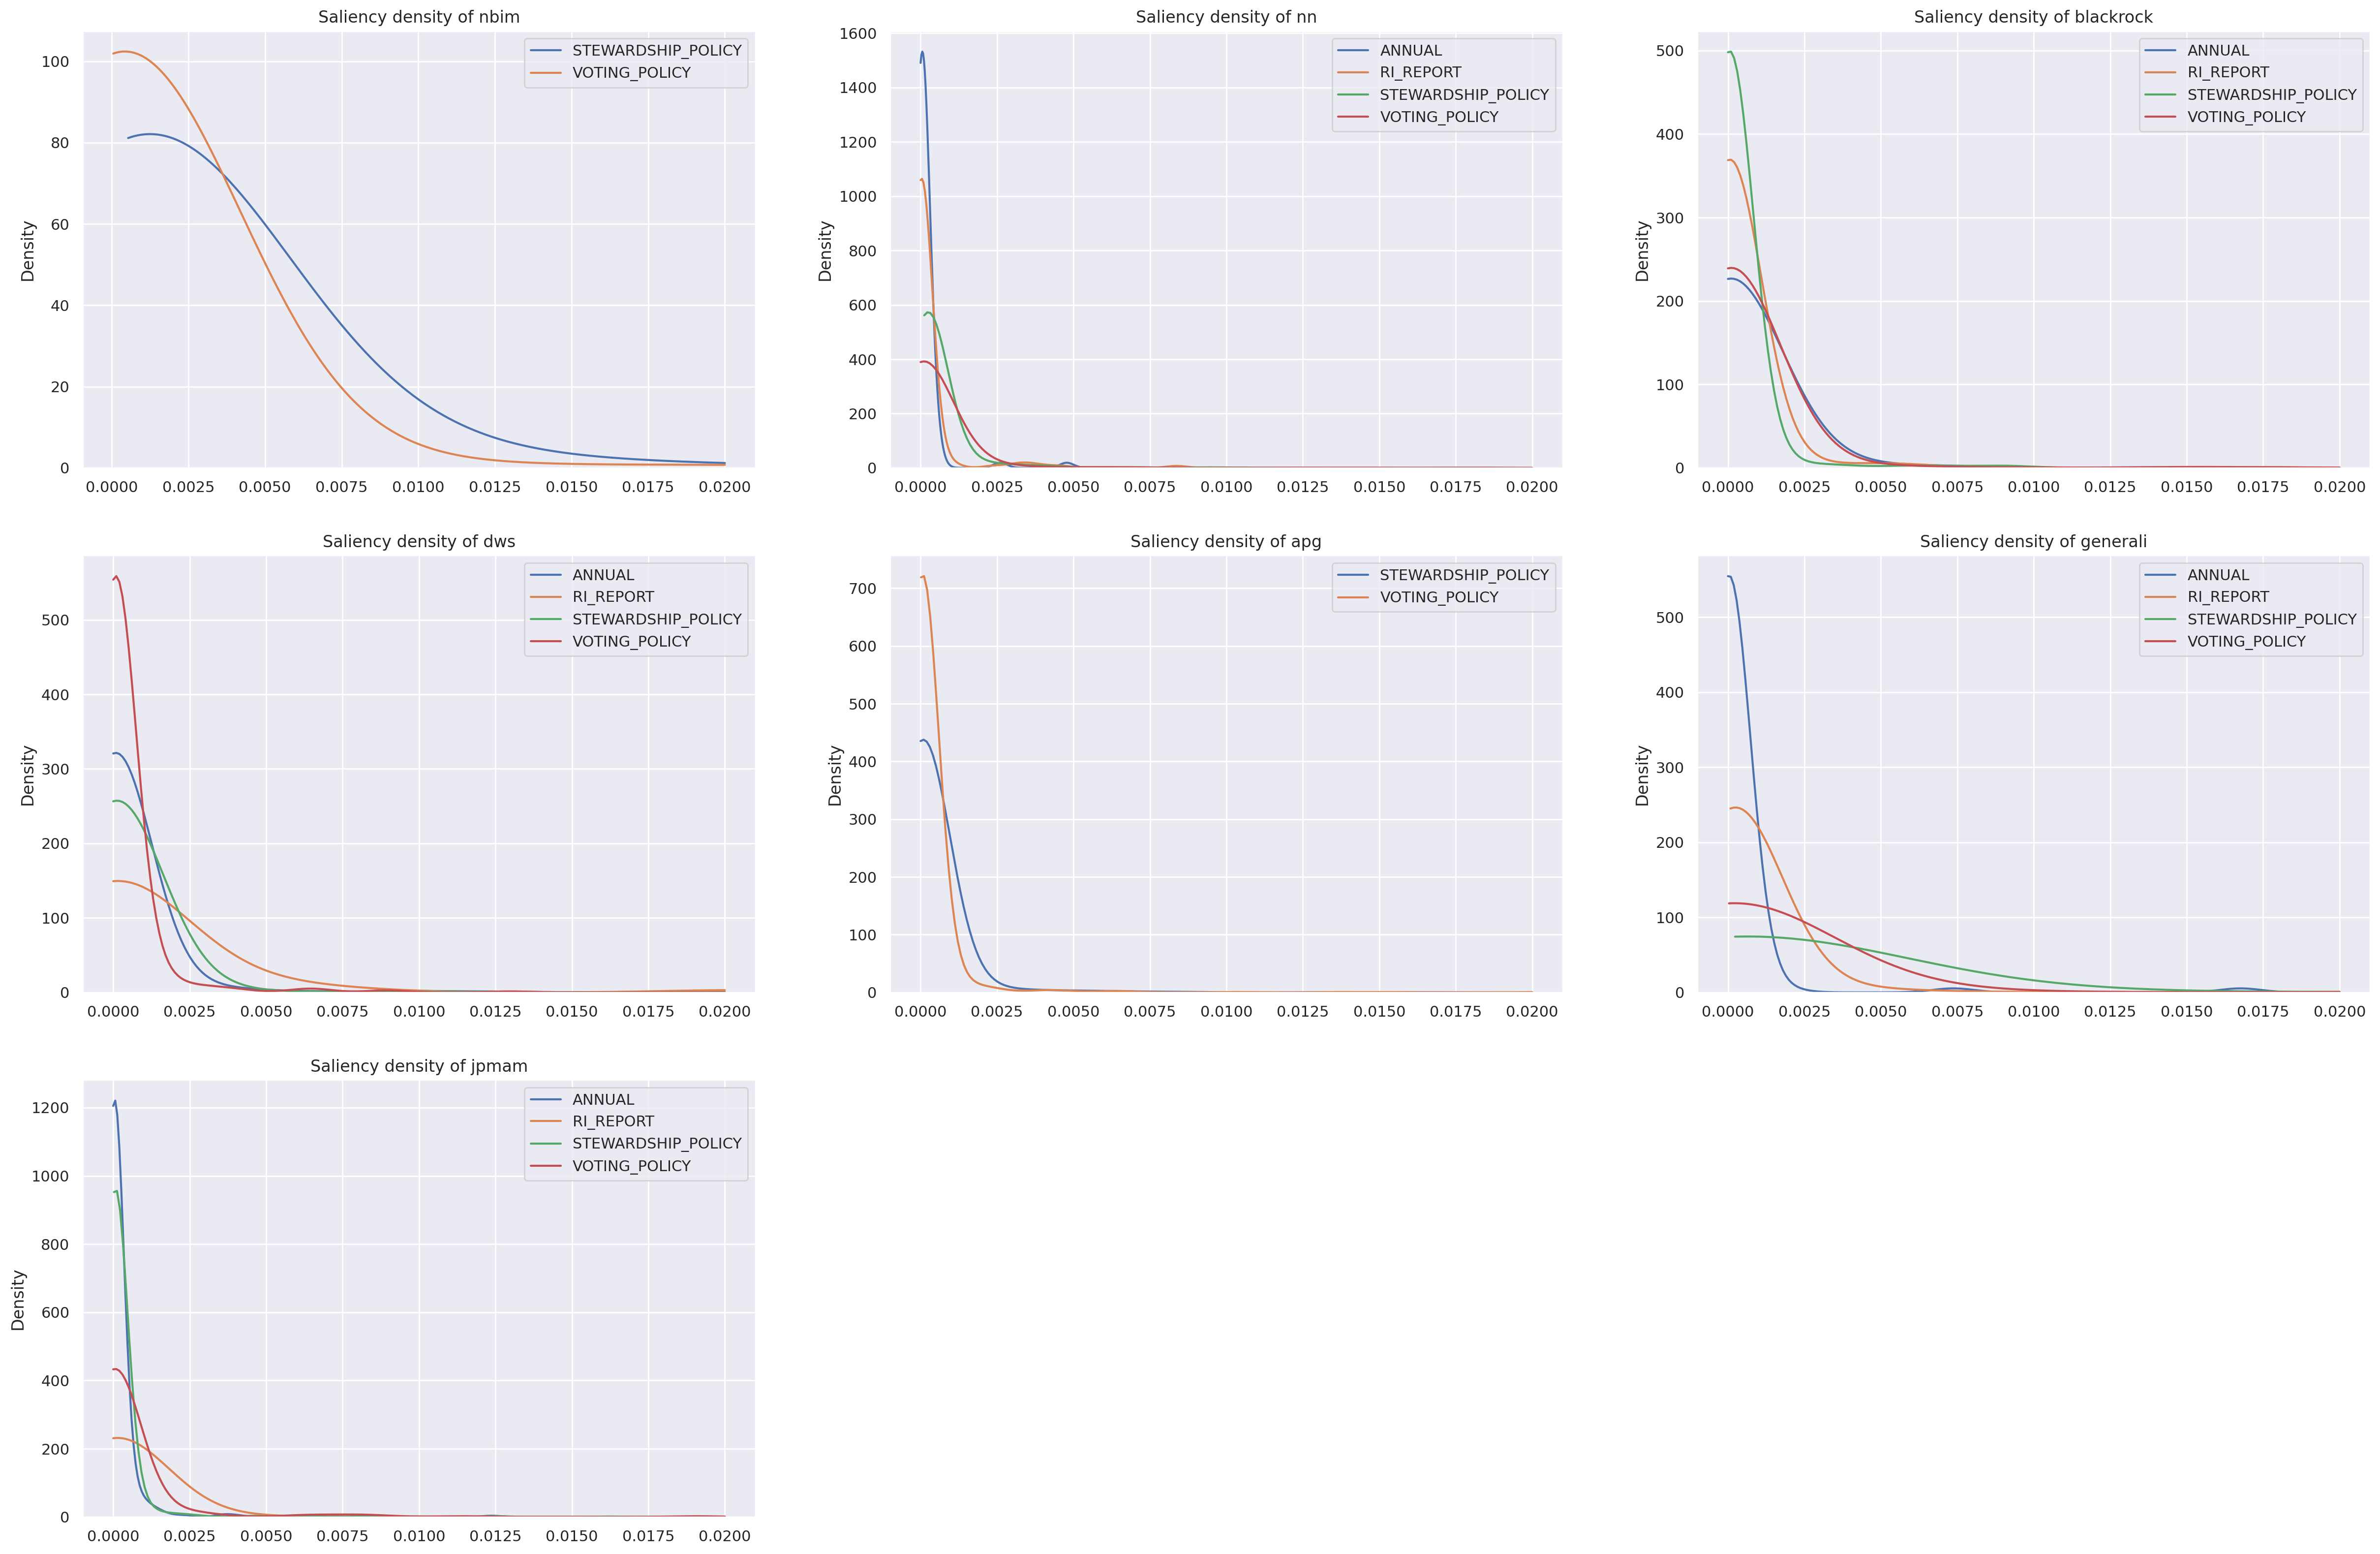

In [34]:
columns = 3
rows = math.ceil(len(companies) / columns)

fig, axes = plt.subplots(rows, columns, figsize = (30, 20), dpi=200)

for i, ax in enumerate(axes.flat):    
    if i < len(companies):
        company = companies[i]
        labels = []

        for t in types:
            key = f"{t} {company}"
            
            if key in saliency:
                data = list(saliency[key].values())
                lower = min(data)
                upper = .02
                
                if np.var(data) > 0:
                    sns.kdeplot(data, ax = ax, clip=(lower, upper))
                    labels.append(t)
            
        
        ax.legend(labels)
        ax.set_title(f"Saliency density of {company}")
        
    else:
        # Delete empty axes
        fig.delaxes(ax)
    
fig.show()
fig.savefig("plots/saliencies/saliencies_dist.jpg", format="jpg")

## Lenght of documents

In [68]:
grouped_data = { g: {} for g in groups }

for report in reports:
    for group in groups:
        if group in report:
            company = report.replace(f"{group} ", "")
            grouped_data[group][company] = len(saliency[report])
            
            continue
            
size_df = pd.DataFrame.from_dict(grouped_data)

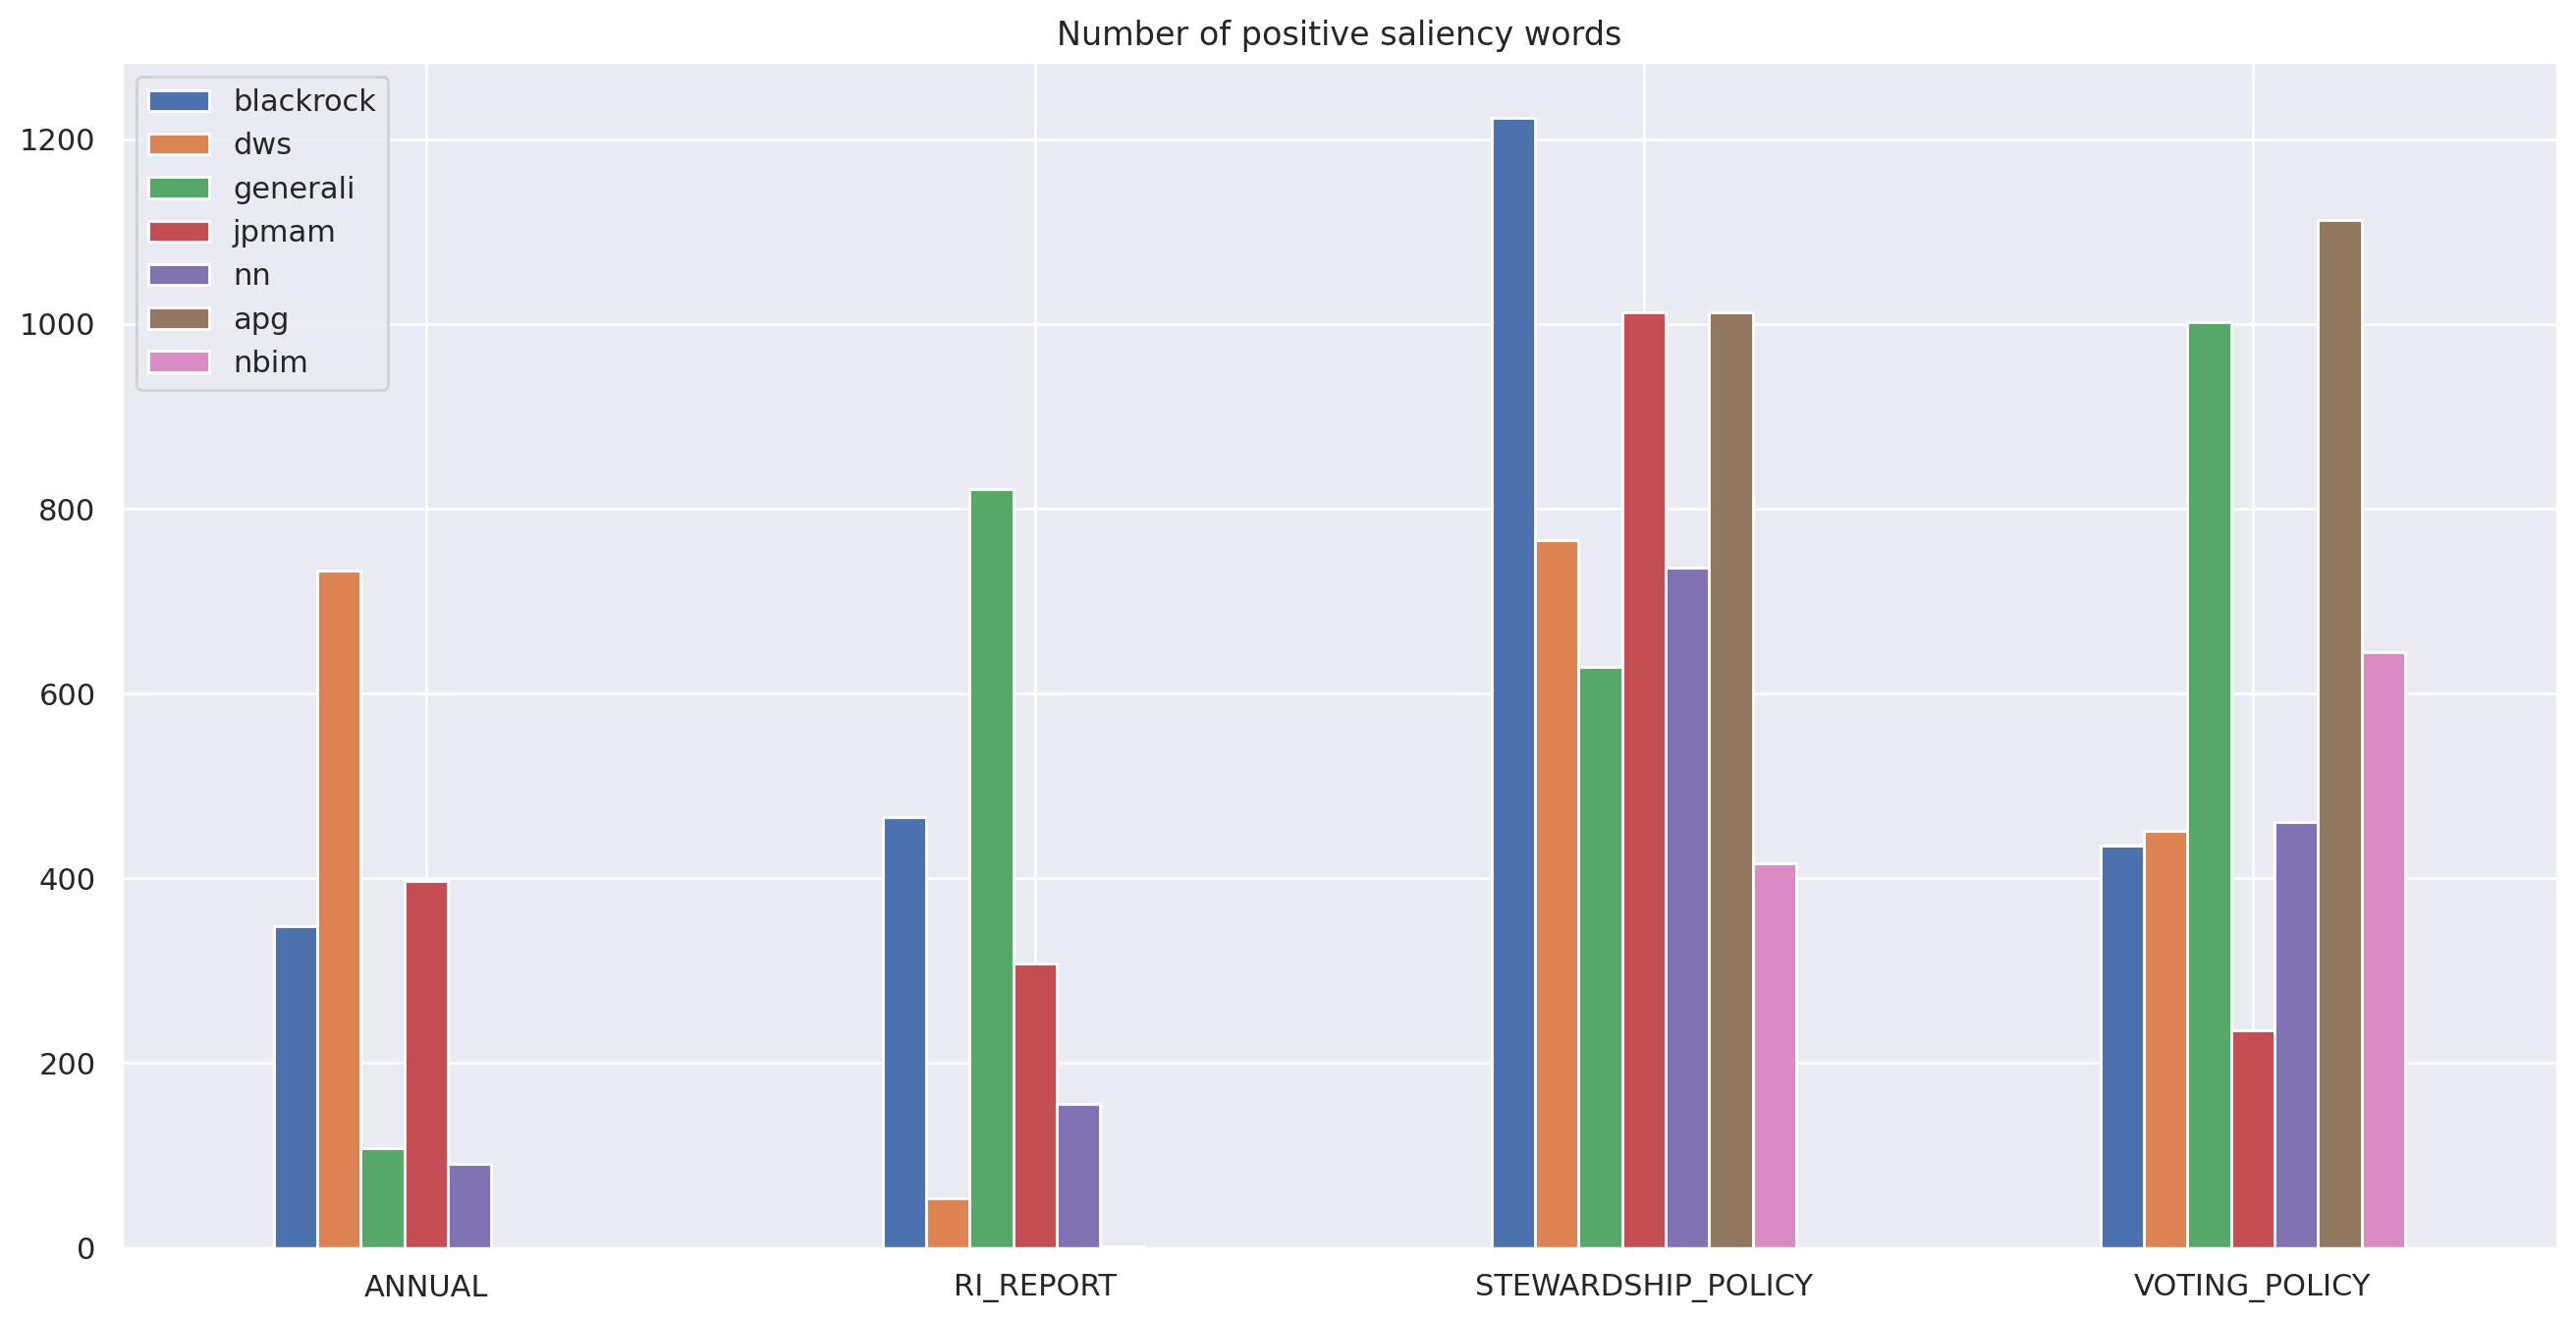

In [69]:
fig, ax = plt.subplots(dpi = 200)

size_df.T.plot.bar(rot=0, ax=ax)
ax.set_title("Number of positive saliency words")

fig.show()
fig.savefig("plots/saliencies/positive_saliency.jpg", format = "jpg")

## Sustainable index, data extraction

In [118]:
sustainable_words = [
    "climate", "green", 
    "sustainable", "sustainability",  
    "environment", "environmental"
]

In [187]:
"""
Computes the saliency index for the words provided
"""
def index(saliency, report, words, **kwargs):
    
    def inword(k):
        for word in words:
            if word in k:
                return word
        
        return False
        
    isinwords = lambda k: any(word in k for word in words)
    
    sal = filter_positive(saliency, report, **kwargs)
    
    total = sum(sal.values())
    sustainable = { inword(k): v for (k, v) in sal.items() if inword(k) }
    
    return { "total": total, **sustainable }

In [188]:
groups = types

In [189]:
def make_index(saliency, groups, reports, sustainable_words):

    grouped_data = { g: {} for g in groups }

    for group in groups:
        dfgroup = {}
        for report in reports:
            if group in report:
                company = report.replace(f"{group} ", "")
                dfgroup[company] = index(saliency, report, sustainable_words)

                continue

        groupdf = pd.DataFrame.from_dict(dfgroup).fillna(0.)
        groupdf.loc["s-index"] = groupdf.loc[groupdf.index != "total"].sum() / groupdf.loc["total"]
        groupdf = groupdf.drop("total", axis = 0)
        grouped_data[group] = groupdf


    df = pd.concat(grouped_data).fillna(0.)
    
    return df

In [190]:
df = make_index(saliency, groups, reports, sustainable_words)

## Sustainability index

In [191]:
total_df = df.swaplevel().loc["s-index"]

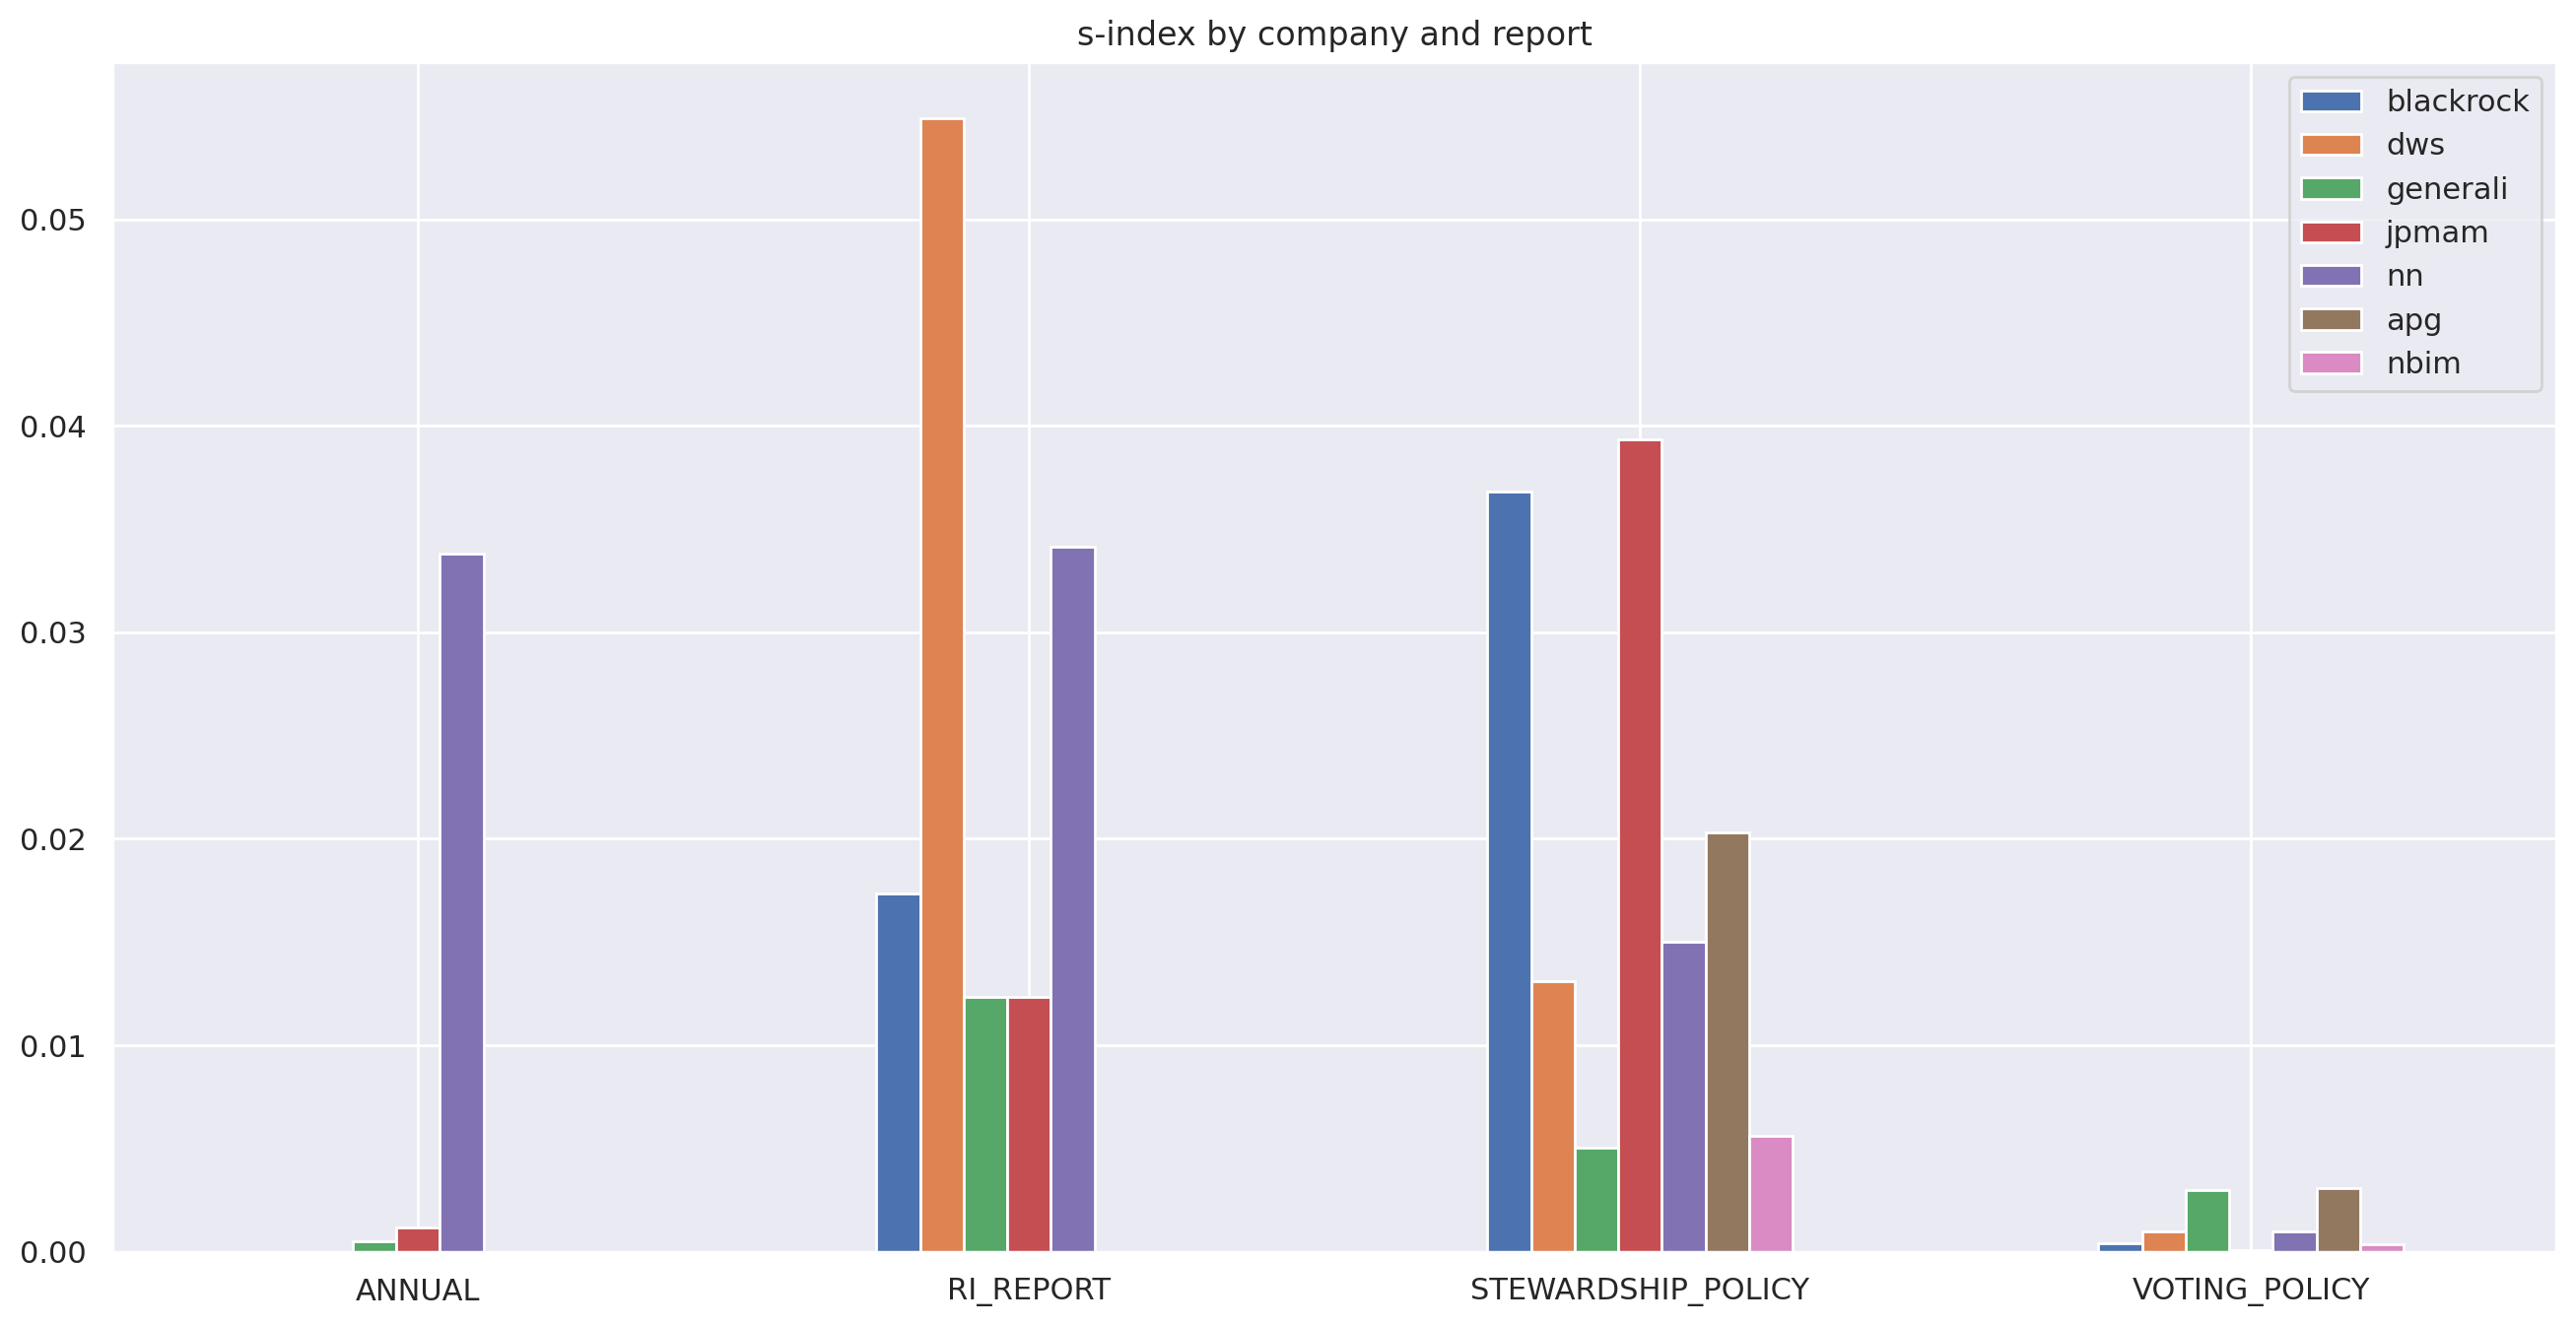

In [192]:
fig, ax = plt.subplots(dpi = 200)

total_df.plot.bar(rot=0, ax=ax)
ax.set_title("s-index by company and report")

fig.show()
fig.savefig("plots/saliencies/sustainable_saliency.jpg", format = "jpg")

## Index breakdown

In [193]:
groupdf.index

Index(['sustainable', 'environmental', 'sustainability', 'climate',
       'environment', 'greenhouse', 'documentssustainabilityrelated'],
      dtype='object')

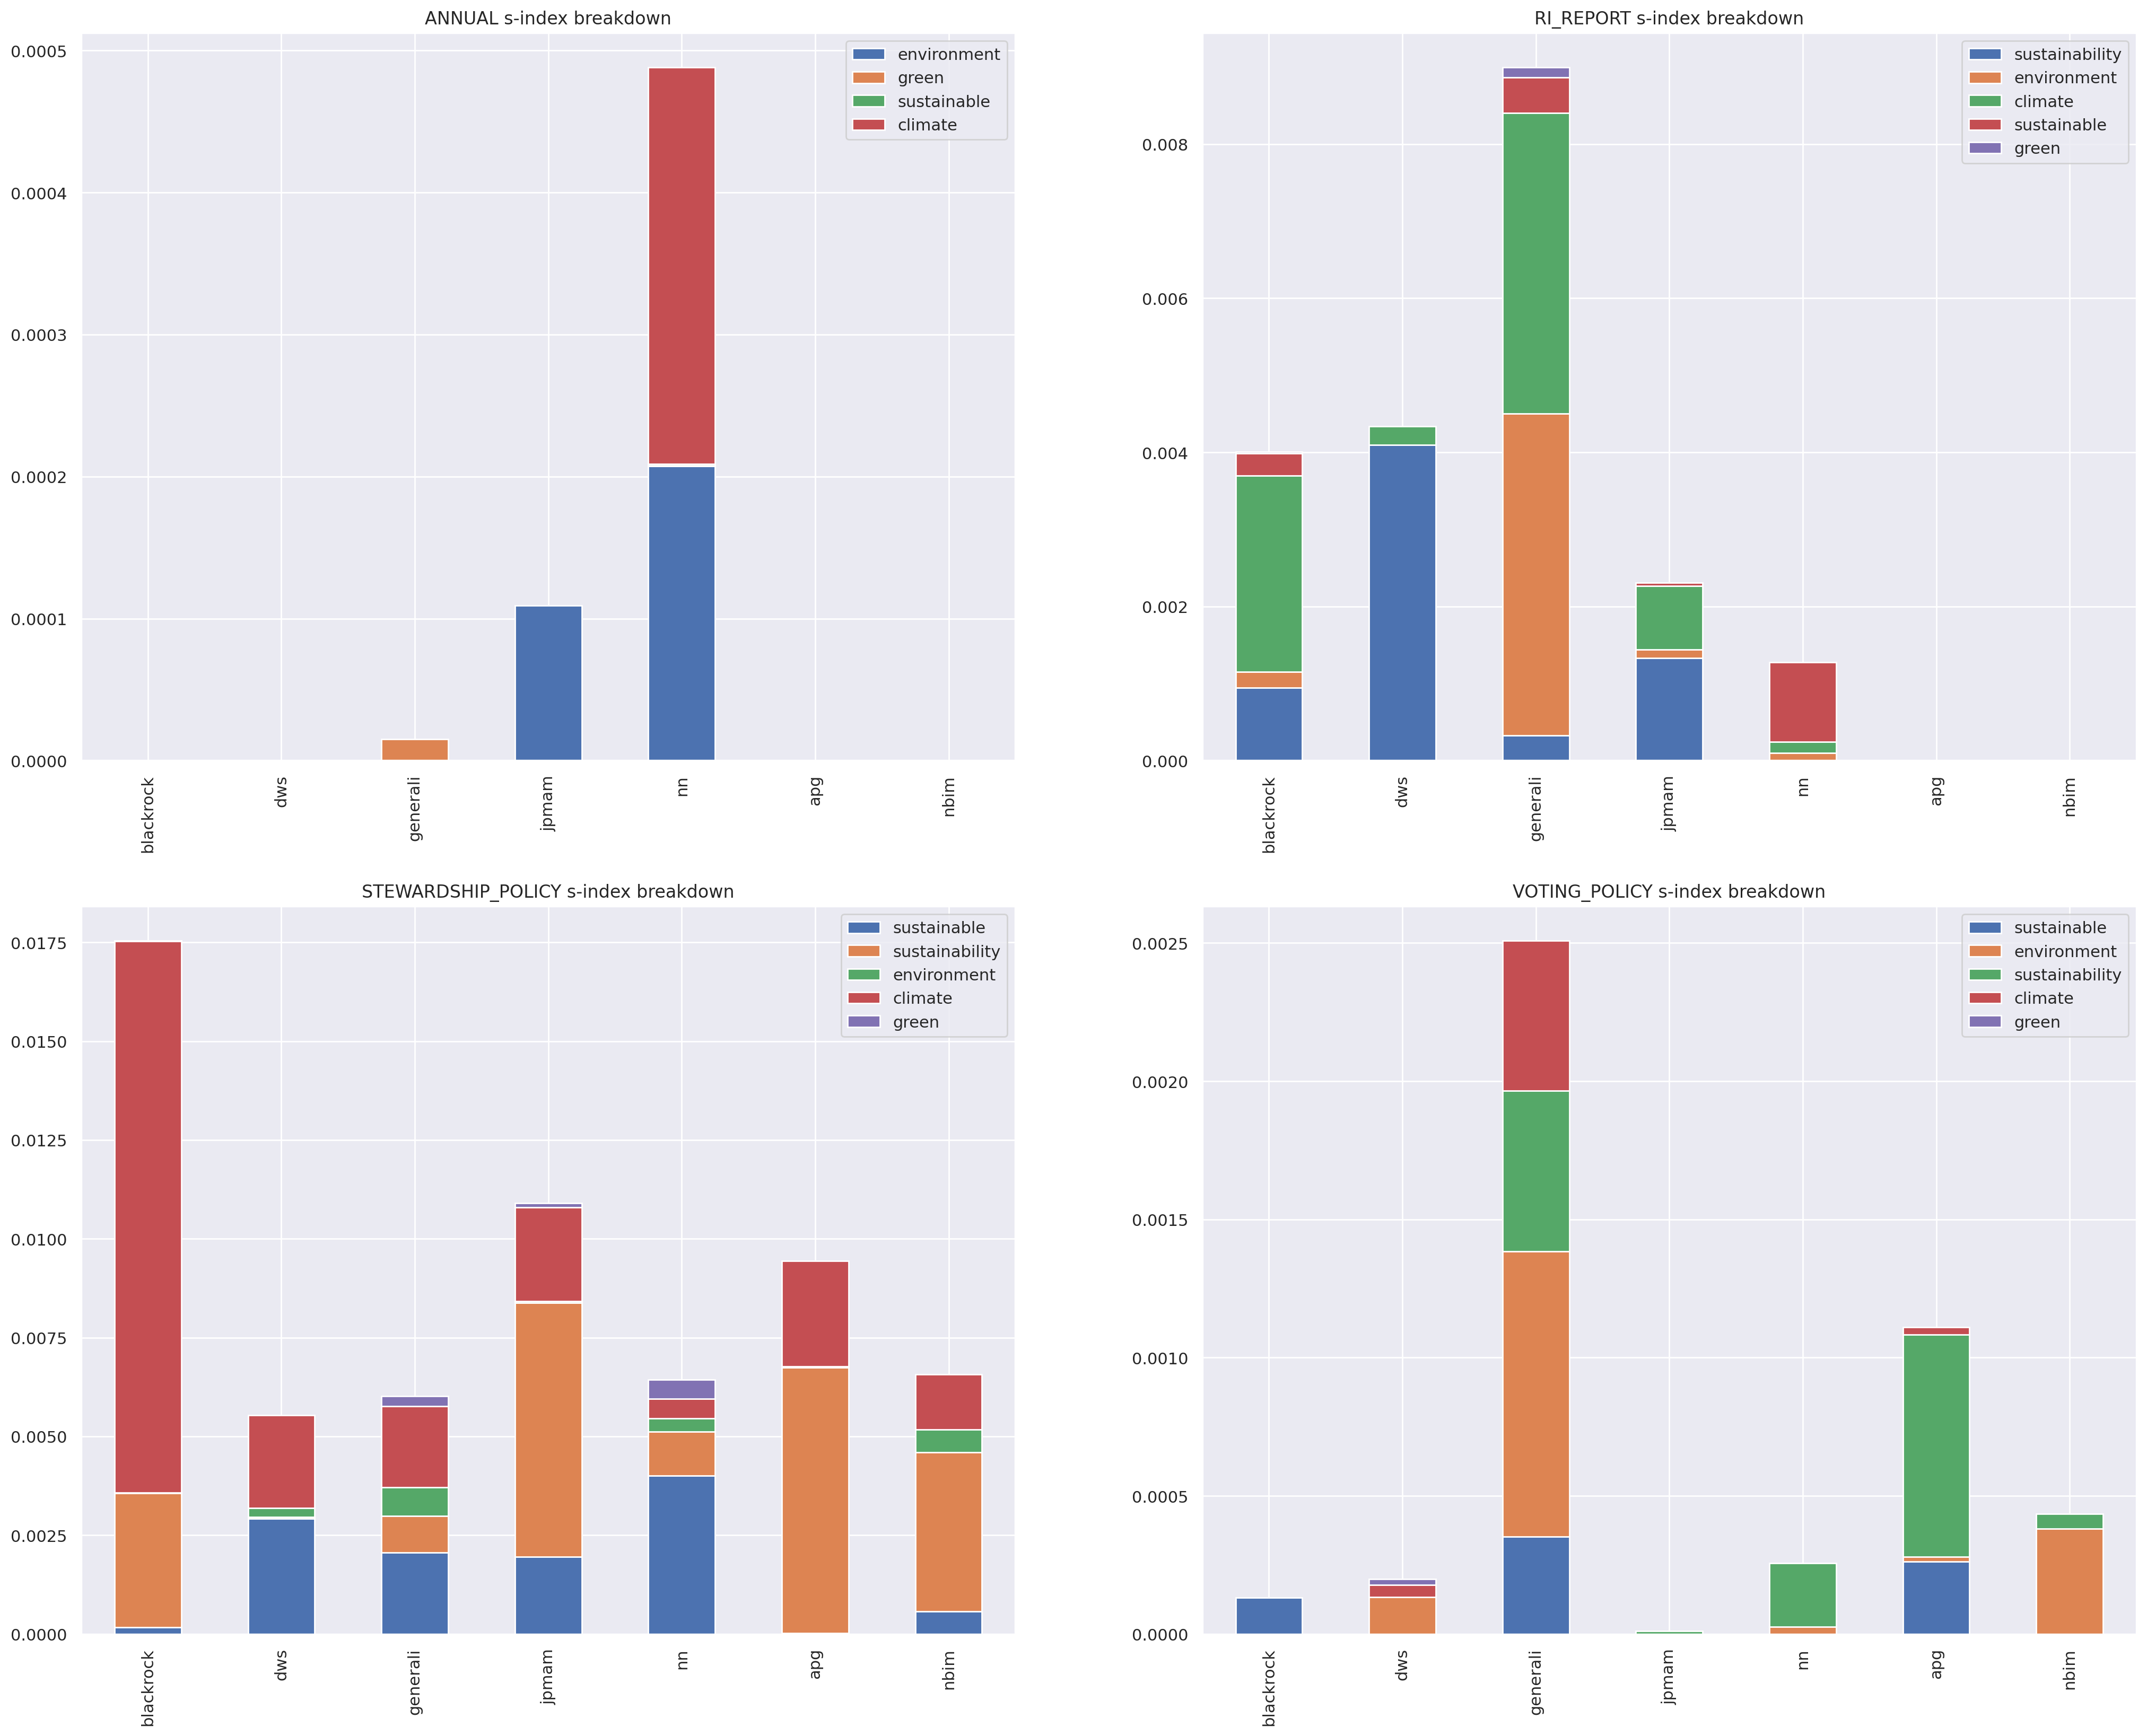

In [199]:
fig, axes = plt.subplots(2, 2, figsize = (25, 20), dpi=200)


for i, ax in enumerate(axes.flat):
    group = groups[i]
    groupdf = df.loc[group].iloc[df.loc[group].index != "s-index"]

    groupdf.T.plot(kind='bar', stacked=True, ax = ax)
    ax.set_title(f"{group} s-index breakdown")


fig.show()
fig.savefig("plots/saliencies/breakdown.jpg", format = "jpg")